<a href="https://colab.research.google.com/github/Islander-0v0-wxin/Milkyway-islander-Movie_Reivews_Llama-3-8B/blob/main/Fine_tuning_Google_Bert_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AI Training Data.csv to AI Training Data (1).csv


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install -q --upgrade transformers==4.40.2

In [ ]:
!pip install "tensorflow ==2.16.1"
!pip install --upgrade tensorflow-hub
!pip install "tf-models-official==2.16.*"
!pip install datasets

  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling tensorflow-2.15.1:
      Successfully uninstalled tensorflow-2.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.
  Using c

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import random

In [ ]:
from datasets import load_dataset
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
import tf_keras as keras
tf.get_logger().setLevel('ERROR')

In [ ]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tensorflow-text, tf-models-official, tf_keras
Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow


### Load the dataset

In [ ]:
# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Load the CSV file into a Pandas DataFrame
df_AI = pd.read_csv(file_name)


In [ ]:
df_AI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5230 entries, 0 to 5229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5230 non-null   object
 1   labels  5230 non-null   int64 
 2   models  5230 non-null   object
dtypes: int64(1), object(2)
memory usage: 122.7+ KB


In [ ]:
df_AI.head()

,text,labels,models
0,"Adventure, that's what it promised, and advent...",1,Google Gemini Pro 1.5
1,Disappointed. Despite the stellar cast and th...,1,Google Gemini Pro 1.5
2,Explodes onto the screen with the force of a s...,1,Google Gemini Pro 1.5
3,"""Forrest Gump"" is a heartwarming tale of one m...",1,GPT-3.5-turbo
4,"""Into the Wild"" is a captivating exploration o...",1,GPT-3.5-turbo


In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb", split="all")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
df_movie = imdb.shuffle(seed=42).select(range(5230))

In [ ]:
df_movie = pd.DataFrame(df_movie)

In [ ]:
df_movie['labels'] = 0
df_movie['models'] = 'human'

In [ ]:
df_movie = df_movie[['text','labels','models']]

In [ ]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5230 entries, 0 to 5229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5230 non-null   object
 1   labels  5230 non-null   int64 
 2   models  5230 non-null   object
dtypes: int64(1), object(2)
memory usage: 122.7+ KB


In [ ]:
df_movie.head()

,text,labels,models
0,This is a nice movie with good performances by...,0,human
1,"If anything, William Girdler was an opportunis...",0,human
2,This is my first Almodavar film. I'll confess ...,0,human
3,Not even worthy of a wet-Sunday afternoon C5 s...,0,human
4,"Well, what can I say about this movie? It's ba...",0,human


In [ ]:
df= pd.concat([df_AI,df_movie])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10460 entries, 0 to 5229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10460 non-null  object
 1   labels  10460 non-null  int64 
 2   models  10460 non-null  object
dtypes: int64(1), object(2)
memory usage: 326.9+ KB


In [ ]:
df.head(10)

,text,labels,models
0,"Adventure, that's what it promised, and advent...",1,Google Gemini Pro 1.5
1,Disappointed. Despite the stellar cast and th...,1,Google Gemini Pro 1.5
2,Explodes onto the screen with the force of a s...,1,Google Gemini Pro 1.5
3,"""Forrest Gump"" is a heartwarming tale of one m...",1,GPT-3.5-turbo
4,"""Into the Wild"" is a captivating exploration o...",1,GPT-3.5-turbo
5,"""La La Land"" is a modern-day musical that pays...",1,GPT-3.5-turbo
6,"""La La Land"" is a whimsical and enchanting mus...",1,GPT-3.5-turbo
7,"""The Dark Knight"" is a dark and gritty superhe...",1,GPT-3.5-turbo
8,"""The Matrix"" is a groundbreaking sci-fi action...",1,GPT-3.5-turbo
9,"""The Shawshank Redemption"" is a timeless class...",1,GPT-3.5-turbo


In [ ]:
df['text'] = df['text'].str.replace('\n', '')

In [ ]:
print(df.isnull().sum()) #check if there is any null data

text      0
labels    0
models    0
dtype: int64


In [ ]:
df.to_csv('/content/drive/My Drive/Research/dataset.csv', index=False) ### save dataset to google drive

In [ ]:
X = df['text']
y = df['labels']

In [ ]:
X.tail()

5225    'I don't understand. None of this makes any se...
5226    Yes, it's on film, it is around 90 minutes lik...
5227    The IMDb plot summary in no way describes the ...
5228    While thinking of "The Great Escape" I allowed...
5229    I got hold of this film on DVD with the title ...
Name: text, dtype: object

### Data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Define the number of folds
num_folds = 10

# Define the KFold object with shuffling enabled
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

### Load model and tokenizer

Cased Models: Cased models maintain the original casing of the input text. For example, "Hello" and "hello" would be treated as distinct tokens. These models are trained on text that preserves the original casing.

Uncased Models: Uncased models convert all text to lowercase during tokenization. For example, both "Hello" and "hello" would be tokenized as the same word. These models are trained on text where casing is ignored.

In [ ]:
from transformers import AutoTokenizer, TFBertModel, BertConfig, BertTokenizer
import torch

Bert_hidden_dropout = 0.2
Bert_att_dropout = 0.2

# Configure DistilBERT's initialization
config = BertConfig(hidden_dropout_prob=Bert_att_dropout,
                    attention_probs_dropout_prob=Bert_hidden_dropout,
                    num_labels = 2, # The number of output labels--2 for binary classification.
                    output_attentions = True, # Whether the model returns attentions weights.
                    output_hidden_states=True)

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", do_lower_case=True, padding = True, pad_token = '[PAD]')
model = TFBertModel.from_pretrained("google-bert/bert-base-uncased", config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for layer in model.layers:
    layer.trainable = False

### Tokenize text

In [ ]:
MAX_LENGTH = 512


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=16, max_length=MAX_LENGTH):

    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             #True or 'longest': Pad to the longest sequence in the batch (or no padding if only a single sequence if provided).
                                             #'max_length': Pad to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.
                                             #False or 'do_not_pad' (default): No padding (i.e., can output a batch with sequences of different lengths).
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False,
                                             return_tensors='tf'

                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])


    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)



# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid.tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())


In [ ]:
type(X_train_ids)


tensorflow.python.framework.ops.EagerTensor

### Initialize the Base Model

In [ ]:
MAX_LENGTH = 512
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
batch_size = 16

def build_model(transformer, max_length=MAX_LENGTH):

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length),
                                            batch_size=batch_size,
                                            name='input_ids',dtype=tf.int32)
    input_attention_layer = tf.keras.layers.Input(shape=(max_length),
                                                 batch_size=batch_size,
                                                 name='attention_mask',dtype=tf.int32)

    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]

    ##                                                 ##
    ## Define additional dropout and dense layers here ##
    ##                                                 ##

    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, # the number of output classes for classification task
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    # Compile the model
    model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  #run_eagerly=True,
                         metrics= [tf.keras.metrics.BinaryAccuracy(),
                             tf.keras.metrics.FalseNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.F1Score(),
                           tf.keras.metrics.AUC(),
                           tf.keras.metrics.AUC(curve='PR'),
                           tf.keras.metrics.AUC(curve='ROC'),
                       ])F


    return model

model = build_model(model)

In [ ]:
model.summary()
# Accessing layers attribute
for layer in model.layers:
    print(layer.name)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(16, 512)]                  0         []                            
                                                                                                  
 attention_mask (InputLayer  [(16, 512)]                  0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(16, 512, 768                                       

### Training Classification Layer Weights

In [ ]:
y_train_np = np.array(y_train.astype('float32'))
y_valid_np = np.array(y_valid.astype('float32'))

In [ ]:
EPOCHS = 6
BATCH_SIZE = 16
NUM_STEPS = len(X_train.index) // BATCH_SIZE
tf.config.run_functions_eagerly(True)

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train_np,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid_np),
    verbose=2,
    )



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/6
457/457 - 333s - loss: 0.4811 - binary_accuracy: 0.8597 - false_negatives: 171.0000 - false_positives: 855.0000 - true_negatives: 2838.0000 - true_positives: 3448.0000 - precision: 0.8013 - recall: 0.9527 - f1_score: 0.6622 - auc: 0.9500 - auc_1: 0.9470 - auc_2: 0.9500 - val_loss: 0.3041 - val_binary_accuracy: 0.9554 - val_false_negatives: 0.0000e+00 - val_false_positives: 70.0000 - val_true_negatives: 695.0000 - val_true_positives: 804.0000 - val_precision: 0.9199 - val_recall: 1.0000 - val_f1_score: 0.6776 - val_auc: 0.9997 - val_auc_1: 0.9997 - val_auc_2: 0.9997 - 333s/epoch - 728ms/step
Epoch 2/6
457/457 - 319s - loss: 0.2707 - binary_accuracy: 0.9808 - false_negatives: 27.0000 - false_positives: 113.0000 - true_negatives: 3576.0000 - true_positives: 3590.0000 - precision: 0.9695 - recall: 0.9925 - f1_score: 0.6623 - auc: 0.9987 - auc_1: 0.9988 - auc_2: 0.9987 - val_loss: 0.1757 - val_binary_accuracy: 0.9777 - val_false_negatives: 0.0000e+00 - val_false_positives: 35.0000

50/50 [==============================] - 10s 197ms/step


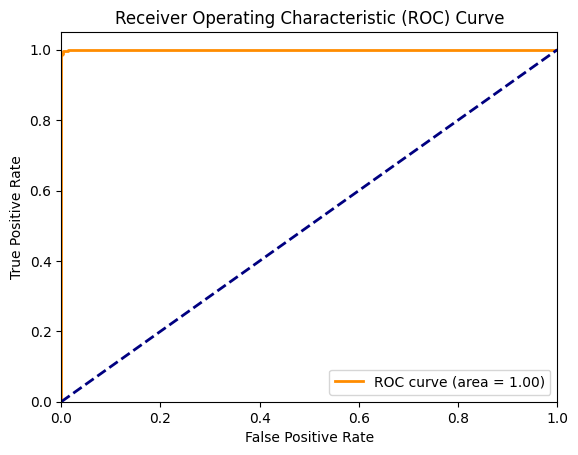

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the validation set
y_pred_proba = model.predict([X_valid_ids, X_valid_attention])

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid_np, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 10s 201ms/step


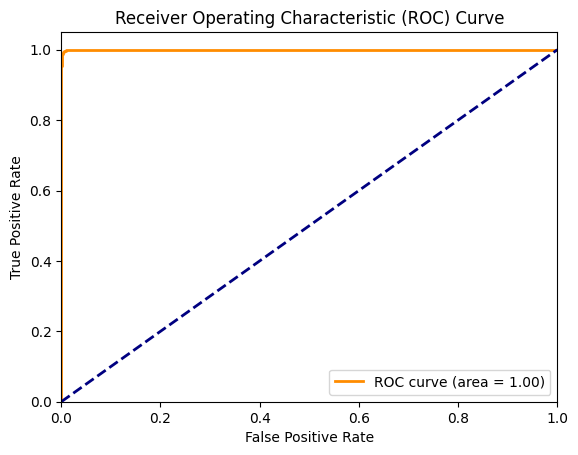

In [ ]:
# Make predictions on the validation set
y_pred_proba = model.predict([X_test_ids, X_test_attention])

y_test_np = np.array(y_test.astype('float32'))
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Make predictions on the validation set
y_pred = model.predict([X_valid_ids, X_valid_attention])
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid_np, y_pred_classes)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 10s 200ms/step
Confusion Matrix:
[[741  24]
 [  0 804]]


### Fine-tuning DistilBERT and Training All Weights

In [ ]:
FT_EPOCHS = 4
BATCH_SIZE = 16
NUM_STEPS = len(X_train.index) // BATCH_SIZE
tf.config.run_functions_eagerly(True)

# Unfreeze distilBERT layers and make available for training
for layer in model.layers:
    layer.trainable = True

# Recompile model after unfreezing
model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),

              #run_eagerly=True,
              metrics= [tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.FalseNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.F1Score(),
                           tf.keras.metrics.AUC(),
                           tf.keras.metrics.AUC(curve='PR'),
                           tf.keras.metrics.AUC(curve='ROC'),
                       ])

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train_np,
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid_np),
    verbose=2
)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7322/7322 - 1322s - loss: 0.0033 - binary_accuracy: 0.9991 - false_negatives_1: 14.0000 - false_positives_1: 13.0000 - true_negatives_1: 14775.0000 - true_positives_1: 14486.0000 - precision_1: 0.9991 - recall_1: 0.9990 - f1_score: 0.6623 - auc_3: 0.9999 - auc_4: 0.9999 - auc_5: 0.9999 - val_loss: 4.5351e-04 - val_binary_accuracy: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 765.0000 - val_true_positives_1: 804.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - val_f1_score: 0.6776 - val_auc_3: 1.0000 - val_auc_4: 1.0000 - val_auc_5: 1.0000 - 1322s/epoch - 181ms/step


In [ ]:
history_df = pd.DataFrame(train_history1.history)
history_df

,loss,binary_accuracy,false_negatives,false_positives,true_negatives,true_positives,precision,recall,f1_score,auc,...,val_false_negatives,val_false_positives,val_true_negatives,val_true_positives,val_precision,val_recall,val_f1_score,val_auc,val_auc_1,val_auc_2
0,0.481131,0.859683,171.0,855.0,2838.0,3448.0,0.801301,0.952749,[0.66215354],0.949987,...,0.0,70.0,695.0,804.0,0.919908,1.0,[0.6776233],0.999720,0.999739,0.999720
1,0.270703,0.980838,27.0,113.0,3576.0,3590.0,0.969484,0.992535,[0.6622722],0.998722,...,0.0,35.0,730.0,804.0,0.958284,1.0,[0.6776233],0.999884,0.999891,0.999884
2,0.176608,0.990556,17.0,52.0,3636.0,3601.0,0.985765,0.995301,[0.6623947],0.999494,...,0.0,29.0,736.0,804.0,0.965186,1.0,[0.6776233],0.999897,0.999904,0.999897
3,0.126915,0.993704,13.0,33.0,3649.0,3611.0,0.990944,0.996413,[0.663129],0.999609,...,0.0,28.0,737.0,804.0,0.966346,1.0,[0.6776233],0.999907,0.999912,0.999907
4,0.097367,0.992335,20.0,36.0,3659.0,3591.0,0.990074,0.994461,[0.6615371],0.999663,...,0.0,26.0,739.0,804.0,0.968675,1.0,[0.6776233],0.999916,0.999921,0.999916
5,0.078550,0.994525,16.0,24.0,3666.0,3600.0,0.993378,0.995575,[0.6621498],0.999689,...,0.0,24.0,741.0,804.0,0.971014,1.0,[0.6776233],0.999927,0.999931,0.999927


In [ ]:
# Save the DataFrame as a CSV file
history_df.to_csv('/content/drive/My Drive/Research/train_history3.csv', index=False)


In [ ]:
history_df2 = pd.DataFrame(train_history2.history)
history_df2
history_df2.to_csv('/content/drive/My Drive/Research/train_history4.csv', index=False)

### Visualize

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

def plot_model(metric="loss", epochs=EPOCHS):
  plt.plot(range(EPOCHS), train_history1.history[metric], c='blue', alpha=0.7, label=f"Training {metric}")
  plt.plot(range(EPOCHS), train_history1.history[f"val_{metric}"], c='red', alpha=0.7, label=f"Validation {metric}")
  plt.title(f"Training Vs Validation {metric}")
  plt.legend(loc="best")
  plt.show()

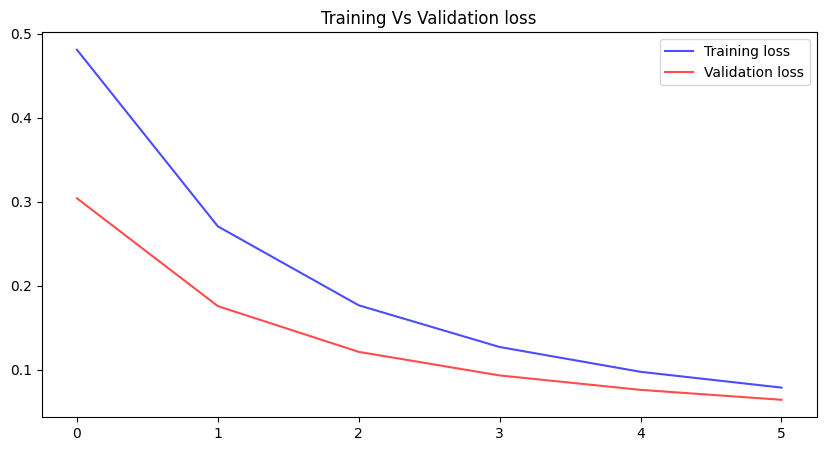

In [ ]:
plot_model(metric="loss")

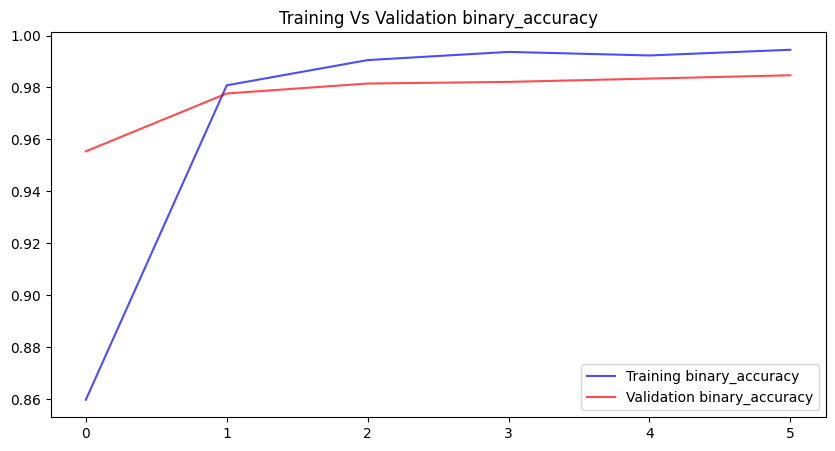

In [ ]:
plot_model(metric="binary_accuracy")

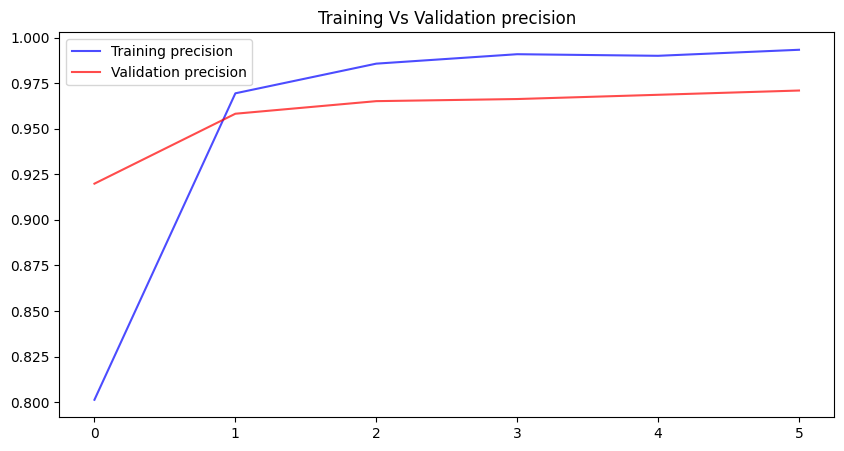

In [ ]:
plot_model(metric="precision")

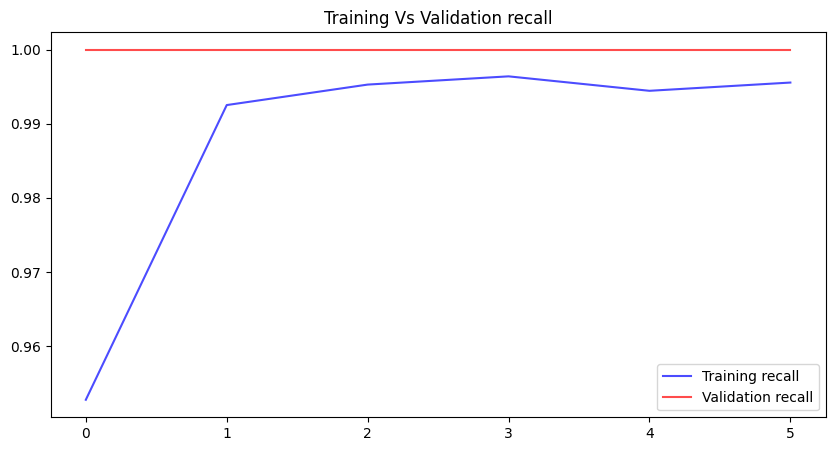

In [ ]:
plot_model(metric="recall")

### Required Formatting

Special Tokens

[SEP]

At the end of every sentence, we need to append the special [SEP] token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).

I am not certain yet why the token is still required when we have only single-sentence input, but it is!

[CLS]

For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

###Add a Classification Head

model’s output is a tuple containing:

last_hidden_state → Word-level embedding of shape (batch_size, sequence_length, hidden_size=768).

hidden_states → [Optional] Tuple of tf.Tensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size=768). Returned when we set

output_hidden_states=True in the config file.
attentions → [Optional] Attention’s weights after the attention softmax, used to compute the weighted average in the self-attention heads. Returned when we set output_attentions=True in the config file.

## Error Analysis

### Saving dataset and model

In [ ]:
!pip install huggingface_hub


In [ ]:
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login, HfApi, HfFolder, Repository


In [ ]:
### convert to huggingface dataset
movie = Dataset.from_pandas(df)

In [ ]:
movie.push_to_hub("AI_Human_generated_movie_reviews", private=False)


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Milkyway-islander/AI_Human_generated_movie_reviews/commit/6bf4f8605f57ab6f1f6151e7828a0c9c8b928465', commit_message='Upload dataset', commit_description='', oid='6bf4f8605f57ab6f1f6151e7828a0c9c8b928465', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Convert the model to SavedModel format
tf.saved_model.save(model, '/content/drive/My Drive/Research/AI_text_detection_bert_model')


In [ ]:
model.save('/content/drive/My Drive/Research/AI_text_detection_bert_model_tfkeras')

In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.saved_model.load('/content/drive/My Drive/Research/AI_text_detection_bert_model')

In [ ]:
print(type(loaded_model))


<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


In [ ]:
from google.colab import files
uploaded1 = files.upload()

Saving train_drcat_04.csv to train_drcat_04.csv


In [ ]:
from transformers import BertTokenizer
s
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

def encode(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'], truncation=True, padding='max_length', max_length=128)

dataset = essay.map(encode, batched=True)
dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'label'])

# Convert to TensorFlow dataset
features = {x: dataset[x].to_tensor(default_value=0, shape=[None]) for x in ['input_ids', 'attention_mask']}
tf_dataset = tf.data.Dataset.from_tensor_slices((features, dataset["label"])).batch(32)